In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [173]:
%%time
data = pd.read_csv('../input/creditcard.csv')
data.shape

CPU times: user 2.26 s, sys: 174 ms, total: 2.44 s
Wall time: 2.44 s


In [174]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [175]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
data['AmountNorm'] = ss.fit_transform(data['Amount'].values.reshape(-1, 1))

## 下采样

[参考](https://www.kaggle.com/dalpozz/in-depth-skewed-data-classif-93-recall-acc-now)。

In [176]:
# 正例（少数）的样本个数
number_records_fraud = len(data[data.Class == 1])
# 欺诈数据的索引列表
fraud_indices = np.array(data[data.Class == 1].index)
# 正常数据的索引列表
normal_indices = data[data.Class == 0].index

In [177]:
# replace=False 表示不放回
random_normal_indices = np.random.choice(
    normal_indices, number_records_fraud, replace=False)

under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = data.iloc[under_sample_indices, :]

In [178]:
# 下采样的样本
X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

In [179]:
from sklearn.model_selection import train_test_split

# 准备训练集和测试集
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(
    X_undersample, y_undersample, test_size=0.3, random_state=666)

## 网格搜索

In [180]:
c_param_range = [0.01, 0.1, 1, 10, 100]

parameters = {'C': c_param_range}

In [181]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(penalty='l1', solver='liblinear')
clf = GridSearchCV(lr, parameters, cv=5, refit=True, scoring='recall')
clf.fit(X_train_undersample, y_train_undersample.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='recall', verbose=0)

In [182]:
clf.best_params_

{'C': 100}

In [183]:
clf.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [184]:
clf.best_score_

0.9133784125379172

In [185]:
y_pred_undersample = clf.predict(X_test_undersample)

In [186]:
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
cnf_matrix

array([[146,   4],
       [ 14, 132]])

In [188]:
cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1])

0.9041095890410958

In [189]:
from sklearn.metrics import recall_score

recall_score(y_test_undersample, y_pred_undersample)

0.9041095890410958

In [204]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

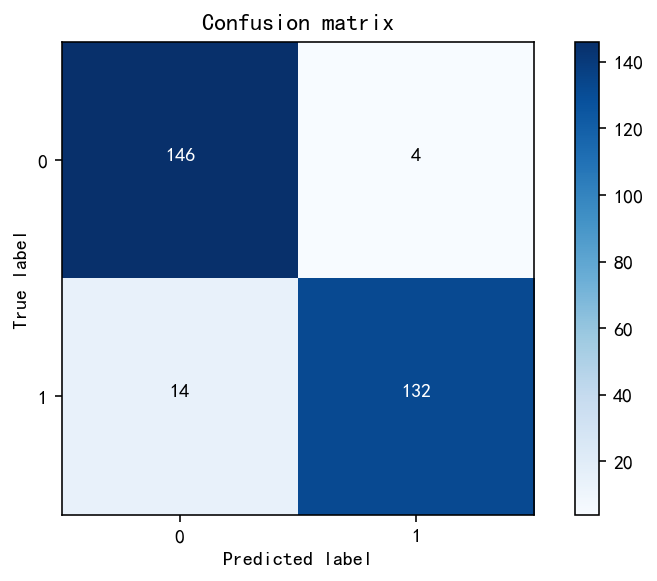

In [207]:
class_names = [0, 1]
plot_confusion_matrix(
    cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()